In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import sys
sys.path.insert(0, '../../../')

import numpy as np
import matplotlib.pyplot as plt
import pickle

from src.difsched.data.DatasetManagerLibs import DatasetConvertor, DatasetReader
from src.difsched.data.TrafficPredictior.libs import PreparingDatasetCA
from src.difsched.data.TrafficPredictior.libs import trainModelCA
from src.difsched.data.TrafficPredictior.libs import evaluateModelCA
from src.difsched.data.TrafficPredictior.libs import createModelCA

from src.difsched.config import getPredictorConfig, visualizePredictorConfig

In [5]:
datasetReader = DatasetReader(parentFolder="Dataset")
datasetConverter = DatasetConvertor()
datasetLabel = "Task0_1_2"
for taskName in ["Task0", "Task1", "Task2"]:
    for fileIndex in datasetReader.readFileIndexsList:
        datasetReader.readRawDataset(f"TrafficDataset/Dataset/{taskName}/exp{fileIndex}/motion.txt", datasetLabel=datasetLabel)

In [6]:
configIdx = 0
config = getPredictorConfig(configIdx)

lenWindow = config['LEN_window']
upsampleK = config['upsampleK']
dataflow = config['dataflow']
dbParameter = config['dbParameter']
alpha = config['alpha']
mode = config['mode']
direction = config['direction']
train_ratio = config['train_ratio']
trainDataAugment = config['trainDataAugment']
smoothFc = config['smoothFc']
smoothOrder = config['smoothOrder']
visualizePredictorConfig(config)

Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [7]:
datasetConverter.registerDataUnit(datasetReader.dfLibrary[datasetLabel])
datasetConverter.generateTrafficByDpdr(dbParameter=dbParameter, alpha=alpha, mode=mode, direction=direction, upsampleK=upsampleK)
datUnit = datasetConverter.getDataUnit(dataflow)

print(f"================== Training Predictor=================")
trainDataAugment = False
verbose = True

paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = train_ratio
paramsCA['dataAugment'] = trainDataAugment
paramsCA['smoothFc'] = smoothFc
paramsCA['smoothOrder'] = smoothOrder
paramsCA['contextDownsample'] = upsampleK

#============= Training =============
trainData, testData, (newLenSource, newLenTarget) = PreparingDatasetCA(datUnit, paramsCA, verbose=verbose)
(contextSrc, contextTrg, _, trafficSrc, trafficTrg, _, transmissionsVector, contextSrcNoSmooth) = trainData
print(f"Context Source shape: {contextSrc.shape}")
print(f"Context Target shape: {contextTrg.shape}")
print(f"Traffic Source shape: {trafficSrc.shape}")
print(f"Traffic Target shape: {trafficTrg.shape}")
print(f"Transmissions Vector shape: {transmissionsVector.shape}")
print(f"Context Source No Smooth shape: {contextSrcNoSmooth.shape}")

if  paramsCA['contextDownsample'] is not None:
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    newLenSource, newLenTarget, trainData, testData, verbose=verbose)
else:
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=verbose)    

========== thumb ============
Forward: Compression rate:0.2725844439255435
========== index ============


KeyboardInterrupt: 

Train size: 624396, Test size: 416265


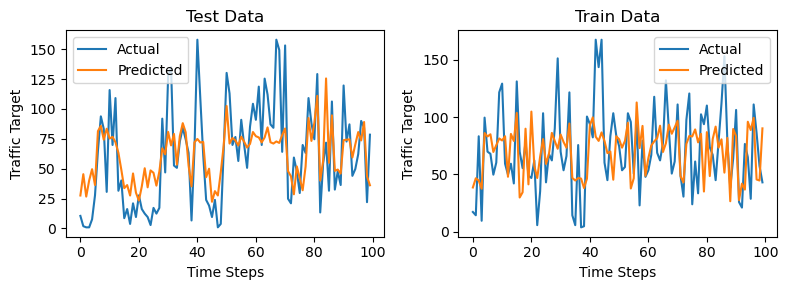

In [ ]:
def UpsampleTraffic(traffic, lenWindow,upsampleK):
    return np.interp(
        traffic,
        np.linspace(0, np.floor(lenWindow/upsampleK+1).astype(int), num=lenWindow+1),
        np.linspace(0, lenWindow+1, num=lenWindow+1)
    )
#============= Evaluatation =============
trafficModelCA, _ = createModelCA(modleParametersCA)
trafficModelCA.load_state_dict(bestWeightsCA)
paramsValid = paramsCA.copy()
paramsValid['dataAugment'] = False
trainData, testData, (newLenSource, newLenTarget) = PreparingDatasetCA(datUnit, paramsValid, verbose=verbose)
resultsTrain = evaluateModelCA(trafficModelCA, trainData)
resultsTest = evaluateModelCA(trafficModelCA, testData)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Test data plot
ax1.plot(UpsampleTraffic(resultsTest['trafficTarget_actual'][0:100], lenWindow, upsampleK), label='Actual')
ax1.plot(UpsampleTraffic(resultsTest['trafficTarget_predicted'][0:100], lenWindow, upsampleK), label='Predicted')
ax1.set_title('Test Data')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Traffic Target')
ax1.legend()

# Train data plot
ax2.plot(UpsampleTraffic(resultsTrain['trafficTarget_actual'][0:100], lenWindow, upsampleK), label='Actual')
ax2.plot(UpsampleTraffic(resultsTrain['trafficTarget_predicted'][0:100], lenWindow, upsampleK), label='Predicted')
ax2.set_title('Train Data')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Traffic Target')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
trafficData = {
    'trafficSource_train_actual':UpsampleTraffic(resultsTrain['trafficSource_actual'], lenWindow, upsampleK),
    'trafficTarget_train_actual': UpsampleTraffic(resultsTrain['trafficTarget_actual'], lenWindow, upsampleK),
    'trafficTarget_train_predicted': UpsampleTraffic(resultsTrain['trafficTarget_predicted'], lenWindow, upsampleK),
    'trafficSource_test_actual':UpsampleTraffic(resultsTest['trafficSource_actual'], lenWindow, upsampleK),
    'trafficTarget_test_actual': UpsampleTraffic(resultsTest['trafficTarget_actual'], lenWindow, upsampleK),
    'trafficTarget_test_predicted': UpsampleTraffic(resultsTest['trafficTarget_predicted'], lenWindow, upsampleK),
}

with open(f'../Results/TrafficData/trafficData_{dataflow}_LenWindow{lenWindow}.pkl', 'wb') as f:
    pickle.dump(trafficData, f)